Connected to ML (Python 3.12.8)

In [79]:
import numpy as np 

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterMathtext
import matplotlib as mpl

import mplhep as hep

import pandas as pd

from scipy.special import erf
from scipy.integrate import quad
from scipy.special import gammaln

from math import factorial

from functools import lru_cache

hep.style.use("CMS")


In [93]:
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "font.size": 18,
    "axes.labelsize": 20,
    "axes.titlesize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.linewidth": 1.4,
    "lines.linewidth": 3,
})

In [90]:
# The toy model

def reduced_mass(m1,m2):
    return (m1*m2)/(m1+m2)

def toy_model_limit(wimp_mass, target_mol_mass):
    flux = 0.3*220e5 / wimp_mass
    n_t = 6.02e23 * 4.2e6 * 3600*24*365 / target_mol_mass
    mu_a = reduced_mass((0.938*target_mol_mass),wimp_mass)
    mu_n = reduced_mass(0.938, wimp_mass)

    ratio = (mu_a/mu_n)**2 * (target_mol_mass**2)

    product = flux * n_t *  ratio
    return 2.3/product *2



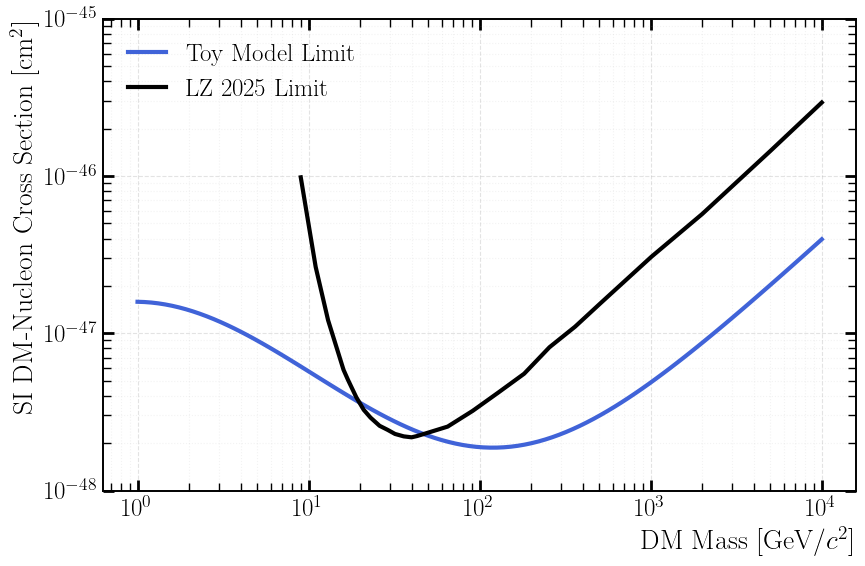

In [94]:
LZ_current_mass, LZ_current_limit = np.loadtxt("Current Global Exclusion/LZ_2025.txt", unpack=True, skiprows=1, usecols=(0,1))

masses = np.logspace(0,4,100)

toy_limit = toy_model_limit(masses, 131.293)

fig, ax = plt.subplots(figsize=(9, 6))

colors = {
    "toy":      "#4063D8",   
    "LZ":       "black",   
}

ax.loglog(masses, toy_limit, color=colors["toy"], label="Toy Model Limit", lw=3)
ax.loglog(LZ_current_mass, LZ_current_limit, color=colors["LZ"], label="LZ 2025 Limit", lw=3)

ax.set_ylim(1e-48, 1e-45)
ax.set_xlabel(r"DM Mass [GeV/$c^2$]")
ax.set_ylabel(r"SI DM-Nucleon Cross Section [cm$^2$]")
ax.grid(True, which="major", ls="--", alpha=0.35)
ax.grid(True, which="minor", ls=":", alpha=0.15)
ax.tick_params(which="major", length=8, width=2.0, direction="in", top=True, right=True)
ax.tick_params(which="minor", length=6, width=1, direction="in", top=True, right=True)
ax.legend(frameon=False)

plt.tight_layout()
plt.savefig("basic_wimp_limit.pdf")   
plt.show()



In [22]:
# Helper Functions - all defined in Lewin and Smith 


def r_mass(m_chi, m_T):
   
    return 4.0 * m_chi * m_T / (m_chi + m_T)**2

def E_o(m_chi, v_0=220e5):
   
    v = v_0 / 3e8        # v/c, matching your original convention
    return 0.5 * m_chi * v**2 * 1e6  # GeV -> keV

def r_0(m_chi, v_0, rho_0=0.3):
  
    return (2.0/np.sqrt(np.pi)) * (6.02e23 * 1e3 / 131.0) * (rho_0 / m_chi) * v_0


def v_min(E_R, v_0, m_chi):
   
    m_T = 0.938 * 131.0  # target nucleus mass in GeV
    return np.sqrt(E_R / (E_o(m_chi, v_0) * r_mass(m_chi, m_T))) * v_0

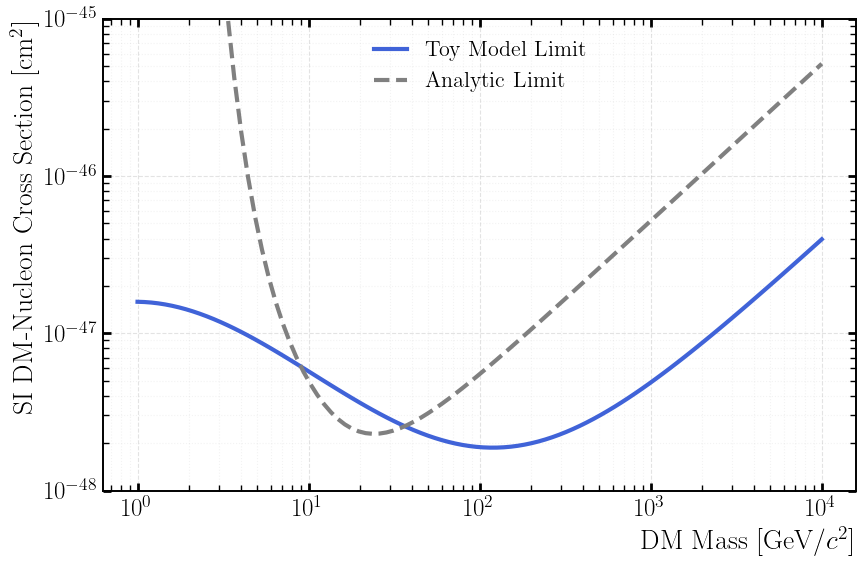

In [95]:
#Using a velocity integral but not escape velocity. f(v) is not truncated

def diff_rate_base(E_R, m_chi, v_0=220e5, rho_0=0.3):
    """
    Differential rate under the analytic 'base assumptions':
      - untruncated Maxwellian
      - no Earth motion
      - F^2 = 1
      -> dR/dE_R = (R0 / (E0 r)) * exp(-E_R / (E0 r))
    """
    m_T = 0.938 * 131.0
    E_R0 = E_o(m_chi, v_0) * r_mass(m_chi, m_T)
    R0   = r_0(m_chi, v_0, rho_0=rho_0)
    return (R0 / E_R0) * np.exp(-E_R / E_R0)

def rate_base(m_chi, lower, upper, v_0=220e5):
    """
    Cross-section limit σ_p^SI(mχ) using the base-assumption spectrum.
    'lower' and 'upper' in eV.
    """
    integral, _ = quad(diff_rate_base, lower, upper, args=(m_chi, v_0))

    exposure = 4200.0 * 3600.0 * 24.0 * 365.0  # kg days
    mu_A = reduced_mass(0.938*131.0, m_chi)
    mu_p = reduced_mass(0.938,        m_chi)
    coherence = (mu_A/mu_p)**2 * 131.0**2

    return 2.3 / (integral * exposure * coherence)

masses = np.logspace(0,4,100)

toy_limit = toy_model_limit(masses, 131.293) 
analytic_limit = [rate_base(m, 5e3, 50e3, 220e5) for m in masses]

fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(masses, toy_limit, color=colors["toy"], label="Toy Model Limit", lw=3)
ax.loglog(masses, analytic_limit, color='grey', label="Analytic Limit", lw=3, ls='--')

ax.set_ylim(1e-48, 1e-45)
ax.set_xlabel(r"DM Mass [GeV/$c^2$]", size = 20)
ax.set_ylabel(r"SI DM-Nucleon Cross Section [cm$^2$]", size = 20)
ax.grid(True, which="major", ls="--", alpha=0.35)
ax.grid(True, which="minor", ls=":", alpha=0.15)
ax.tick_params(which="major", length=6, width=2.0, direction="in", top=True, right=True)
ax.tick_params(which="minor", length=4, width=1, direction="in", top=True, right=True)
ax.legend(frameon=False, fontsize=16)


plt.tight_layout()
plt.savefig("not-truncated_wimp_limit.pdf")
plt.show()

/var/folders/36/ykw8w26j1cv6kjwvxqhzm9940000gn/T/ipykernel_46571/2969132141.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  return 2.3 / (integral * exposure * coherence *0.5)


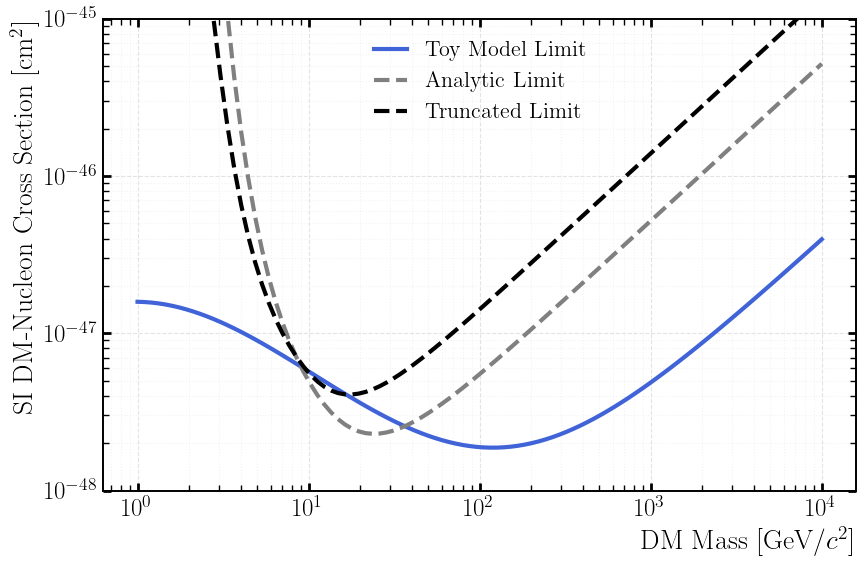

In [96]:
#Using a truncated Maxwell distribution with escape velocity and Earth motion (assumed to be constant)

def eta_halo(vmin, v_0, v_esc, v_e):
    
    z = v_esc / v_0
    N = erf(z) - 2.0/np.sqrt(np.pi) * z * np.exp(-z*z)  # normalization

    # Region 3: kinematically forbidden
    if vmin >= v_esc + v_e:
        return 0.0

    x  = vmin / v_0
    xe = v_e  / v_0

    # Region 1: vmin < vesc - vE
    if vmin < v_esc - v_e:
        return (erf(x+xe) - erf(x-xe)
                - 4.0/np.sqrt(np.pi)*xe*np.exp(-z*z)) / (2.0 * N * v_e)

    # Region 2: vesc - vE <= vmin < vesc + vE
    return (erf(z) - erf(x-xe)
            - 2.0/np.sqrt(np.pi)*(v_esc - vmin)/v_0*np.exp(-z*z)) / (2.0 * N * v_e)

def diff_rate_full(E_R, m_chi, v_0=220e5, v_esc=544e5, v_e=232e5, rho_0=0.3):
   
    vmin = v_min(E_R, v_0, m_chi)
    if vmin >= v_esc + v_e:
        return 0.0

    m_T  = 0.938 * 131.0
    E_R0 = E_o(m_chi, v_0) * r_mass(m_chi, m_T)
    R0   = r_0(m_chi, v_0, rho_0=rho_0)


    T = (np.sqrt(np.pi) / 2.0) * v_0 * eta_halo(vmin, v_0, v_esc, v_e)

    return (R0 / E_R0) * T

def rate_full(m_chi, lower, upper, v_0=220e5, v_esc=544e5, v_e=232e5, rho_0=0.3):
    
    integral, _ = quad(
        diff_rate_full, lower, upper,
        args=(m_chi, v_0, v_esc, v_e, rho_0)
    )

    exposure = 4200.0 * 3600.0 * 24.0 * 365.0  # kg days
    mu_A = reduced_mass(0.938*131.293, m_chi)
    mu_p = reduced_mass(0.938,        m_chi)
    coherence = (mu_A/mu_p)**2 * 131.293**2

    return 2.3 / (integral * exposure * coherence *0.5)


masses = np.logspace(0,4,100)

toy_limit = toy_model_limit(masses, 131.293) 
analytic_limit = [rate_base(m, 5e3, 50e3, 220e5) for m in masses]
truncated_limit = [rate_full(m, 5e3, 50e3, 220e5) for m in masses]


fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(masses, toy_limit, color=colors["toy"], label="Toy Model Limit", lw=3)
ax.loglog(masses, analytic_limit, color='gray', label="Analytic Limit", lw=3, ls='--')
ax.loglog(masses, truncated_limit, color='black', label="Truncated Limit", lw=3, ls='--')

ax.set_ylim(1e-48, 1e-45)
ax.set_xlabel(r"DM Mass [GeV/$c^2$]", size = 20)
ax.set_ylabel(r"SI DM-Nucleon Cross Section [cm$^2$]", size = 20)
ax.grid(True, which="major", ls="--", alpha=0.35)
ax.grid(True, which="minor", ls=":", alpha=0.15)
ax.tick_params(which="major", length=6, width=2.0, direction="in", top=True, right=True)
ax.tick_params(which="minor", length=4, width=1, direction="in", top=True, right=True)
ax.legend(frameon=False, fontsize=16)


plt.tight_layout()
plt.savefig("truncated_wimp_limit.pdf")
plt.show()

/var/folders/36/ykw8w26j1cv6kjwvxqhzm9940000gn/T/ipykernel_46571/142140808.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  return 2.3 / (integral * exposure * coherence * 0.5)
/var/folders/36/ykw8w26j1cv6kjwvxqhzm9940000gn/T/ipykernel_46571/2969132141.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  return 2.3 / (integral * exposure * coherence *0.5)


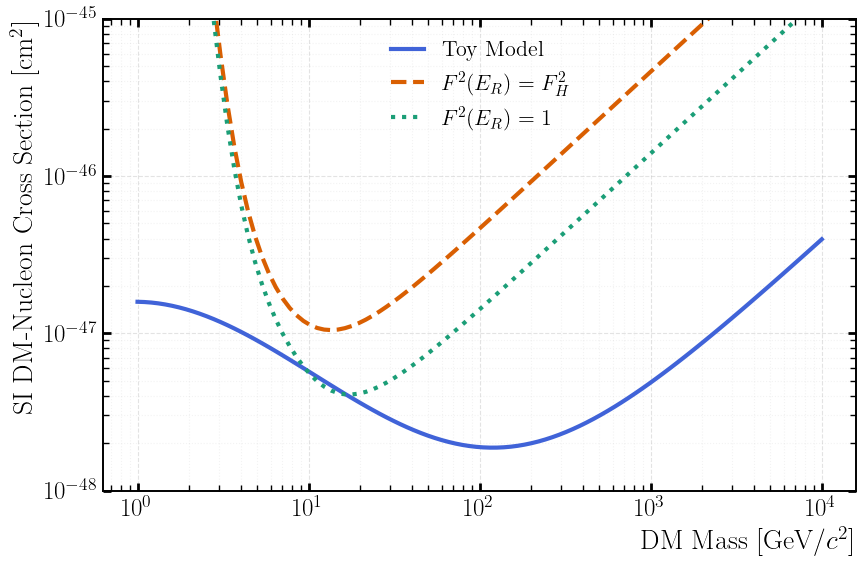

In [98]:
# Accounting for the loss of coherence at high energy 

def helm_form_factor(E_R, A):

    E = E_R * 1e-3


    m_T = 0.938 * A  # GeV
    q = np.sqrt(2 * m_T * E)  


    q_fm = q / 197.3269804

    R = 1.2 * A**(1/3)        
    s = 0.9                   
    R1 = np.sqrt(R*R - 5*s*s)

    if q_fm == 0:
        return 1.0  

    j1 = (np.sin(q_fm*R1)/(q_fm*R1)**2
          - np.cos(q_fm*R1)/(q_fm*R1))

    F = 3 * j1 / (q_fm*R1) * np.exp(-(q_fm*s)**2 / 2.0)
    return F*F

def form_factor_diff_rate(E_R, m_chi, v_0=220e5, v_esc=544e5, v_e=232e5, A=131.293,rho_0=0.3):
   
    vmin = v_min(E_R, v_0, m_chi)
    if vmin >= v_esc + v_e:
        return 0.0

    m_T  = 0.938 * 131.0
    E_R0 = E_o(m_chi, v_0) * r_mass(m_chi, m_T)
    R0   = r_0(m_chi, v_0, rho_0=rho_0)


    T = (np.sqrt(np.pi) / 2.0) * v_0 * eta_halo(vmin, v_0, v_esc, v_e)

    return (R0 / E_R0) * T * helm_form_factor(E_R, A)

def form_factor_rate(m_chi, lower, upper, v_0=220e5, v_esc=544e5, v_e=232e5,A=131, rho_0=0.3):
   
    integral, _ = quad(
        form_factor_diff_rate, lower, upper,
        args=(m_chi, v_0, v_esc, v_e, A, rho_0)
    )

    exposure = 4200.0 * 3600.0 * 24.0 * 365.0  
    mu_A = reduced_mass(0.938*A, m_chi)
    mu_p = reduced_mass(0.938,        m_chi)
    coherence = (mu_A/mu_p)**2 * A**2

    return 2.3 / (integral * exposure * coherence * 0.5)

masses = np.logspace(0,4,100)

toy_limit = toy_model_limit(masses, 131.293) 
form_factor_limit = [form_factor_rate(m, 5e3, 50e3, 220e5) for m in masses]
truncated_limit = [rate_full(m, 5e3, 50e3, 220e5) for m in masses]

colors = {
    "toy":      "#4063D8",   
    "form":       "#D95F02",   
    "truncated":     "#1B9E77",   
}

fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(masses, toy_limit, color=colors["toy"], label="Toy Model", lw=3)
ax.loglog(masses, form_factor_limit, color=colors['form'], label=r"$F^2(E_R)=F^2_H$", lw=3, ls='--')
ax.loglog(masses, truncated_limit, color=colors['truncated'], label=r"$F^2(E_R)=1$", lw=3, ls=':')

ax.set_ylim(1e-48, 1e-45)
ax.set_xlabel(r"DM Mass [GeV/$c^2$]", size = 20)
ax.set_ylabel(r"SI DM-Nucleon Cross Section [cm$^2$]", size = 20)
ax.grid(True, which="major", ls="--", alpha=0.35)
ax.grid(True, which="minor", ls=":", alpha=0.15)
ax.tick_params(which="major", length=6, width=2.0, direction="in", top=True, right=True)
ax.tick_params(which="minor", length=4, width=1, direction="in", top=True, right=True)
ax.legend(frameon=False, fontsize=16)

plt.tight_layout()
plt.savefig("form-factor_wimp_limit.pdf")
plt.show()

/var/folders/36/ykw8w26j1cv6kjwvxqhzm9940000gn/T/ipykernel_46571/142140808.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  return 2.3 / (integral * exposure * coherence * 0.5)


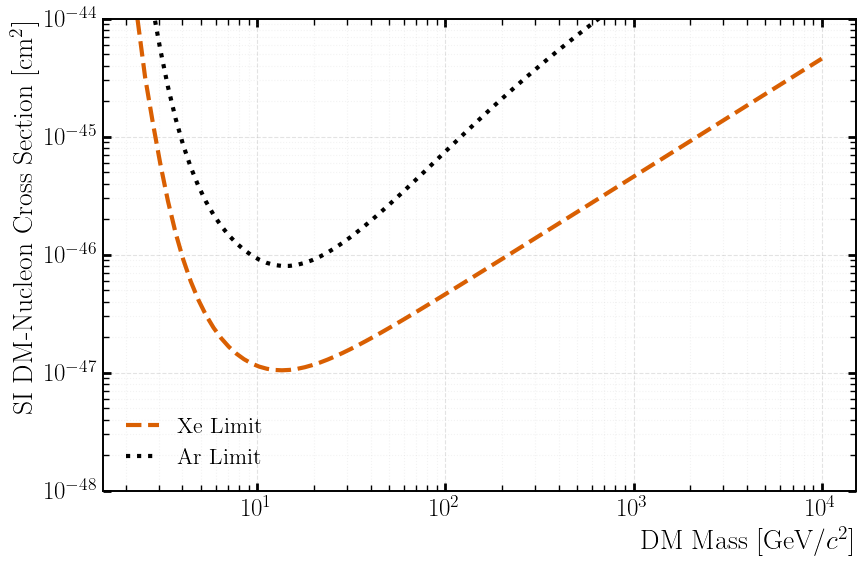

In [99]:
# Comparing LXe and LAr detectors

masses = np.logspace(0,4,100)

lxe_limit = [form_factor_rate(m, 5e3, 50e3, 220e5,A=131.293) for m in masses]
lar_limit = [form_factor_rate(m, 5e3, 50e3, 220e5,A=39.948) for m in masses]

fig, ax = plt.subplots(figsize=(9, 6))

ax.loglog(masses, lxe_limit, color=colors['form'], label=r"Xe Limit", lw=3, ls='--')
ax.loglog(masses, lar_limit, color='black', label=r"Ar Limit", lw=3, ls=':')

ax.set_ylim(1e-48, 1e-44)
ax.set_xlabel(r"DM Mass [GeV/$c^2$]", size = 20)
ax.set_ylabel(r"SI DM-Nucleon Cross Section [cm$^2$]", size = 20)
ax.grid(True, which="major", ls="--", alpha=0.35)
ax.grid(True, which="minor", ls=":", alpha=0.15)
ax.tick_params(which="major", length=6, width=2.0, direction="in", top=True, right=True)
ax.tick_params(which="minor", length=4, width=1, direction="in", top=True, right=True)
ax.legend(frameon=False, fontsize=16)

plt.tight_layout()
plt.savefig("lxe_vs_lar_wimp_limit.pdf")
plt.show()

In [59]:
# Modelling the detection as induvidual quanta following poisson distribution

def lindhard_yield(E_R, Z=54, k=0.166):

    E = E_R * 1e-3

    epsilon = 11.5 * E * Z**(-7/3)
    g = 3*epsilon**0.15 + 0.7*epsilon**0.6 + epsilon

    return (k * g) / (1 + k * g)

def mean_quanta(E_R,W):
    Y = lindhard_yield(E_R)     
    return (E_R * Y) / W

@lru_cache(None)


@lru_cache(None)
def poisson_pmf(n, lam):
    
    if lam <= 0:
        return 1.0 if n == 0 else 0.0
    if n < 0:
        return 0.0


    logP = n * np.log(lam) - lam - gammaln(n + 1.0)


    if logP < -50.0:   
        return 0.0

    return np.exp(logP)



def dRdE_poisson(E_obs, m_chi, dRdE_true, v_0=220e5, v_esc=544e5, v_e=232e5,W=11.5):
    

    n_obs = int(np.floor(E_obs / W))
    if n_obs < 0:
        return 0.0

    def integrand(E_R):
        
        lam = mean_quanta(E_R, W)  
                         
        P   = poisson_pmf(n_obs, lam)          
        dRdE = dRdE_true(E_R, m_chi, v_0, v_esc, v_e)



    E_max = 200e3  
    val, _ = quad(integrand, 0.0, E_max)
    return val


def rate_full_poisson(m_chi, E_low, E_high,
                      v_0=220e5, v_esc=544e5, v_e=232e5, W=11.5):


    def dRdE_obs(E):
        return dRdE_poisson(E, m_chi, form_factor_diff_rate, v_0, v_esc, v_e, W)


    integral, _ = quad(dRdE_obs, E_low, E_high)

    exposure = 5000.0 * 3600.0 * 24.0 * 365.0  
    mu_A = reduced_mass(0.938*131.0, m_chi)
    mu_p = reduced_mass(0.938,        m_chi)
    coherence = (mu_A/mu_p)**2 * 131.0**2

    return 2.3 / (integral * exposure * coherence * 0.5)

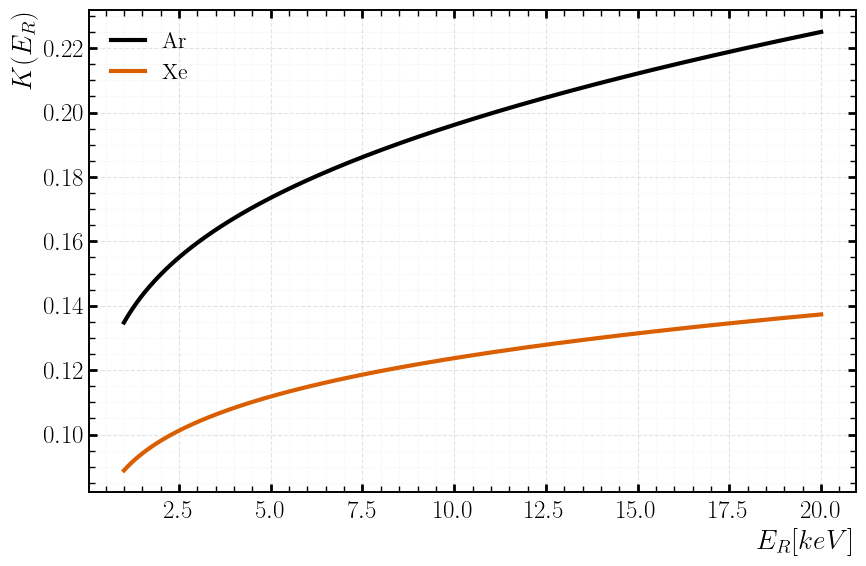

In [100]:
# Plotting Lindhard Yields for LXe and LAr k values from https://arxiv.org/pdf/2303.13441

E_R = np.linspace(1e3, 20e3, 500)  

Y_Ar = lindhard_yield(E_R, Z=18, k=0.095)
Y_Xe = lindhard_yield(E_R, Z=54, k=0.09)

fig, ax = plt.subplots(figsize=(9, 6))



ax.plot(E_R*1e-3, Y_Ar, label='Ar', color='black')
ax.plot(E_R*1e-3, Y_Xe, label='Xe', color=colors['form'])

ax.set_xlabel(r"$E_R [keV]$", size = 20)
ax.set_ylabel(r"$K(E_R)$", size = 20)



ax.grid(True, which="major", ls="--", alpha=0.35)
ax.grid(True, which="minor", ls=":", alpha=0.15)


ax.tick_params(which="major", length=6, width=2.0, direction="in", top=True, right=True)
ax.tick_params(which="minor", length=4, width=1, direction="in", top=True, right=True)
ax.legend(frameon=False, fontsize=16)
plt.tight_layout()


plt.savefig("Lindhard_model.pdf")   

plt.show()

/var/folders/36/ykw8w26j1cv6kjwvxqhzm9940000gn/T/ipykernel_46571/142140808.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  return 2.3 / (integral * exposure * coherence * 0.5)


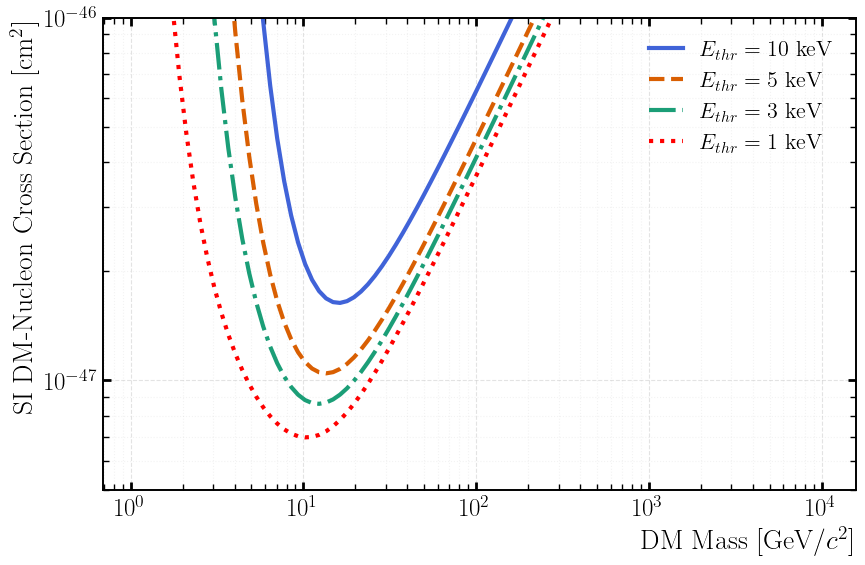

In [101]:
# Comparison of lowering E_thr

masses = np.logspace(0,4,100)
limit_10kev = [form_factor_rate(m, 10e3, 50e3, 220e5,A=131.293) for m in masses]
limit_5kev = [form_factor_rate(m, 5e3, 50e3, 220e5,A=131.293) for m in masses]
limit_3kev  = [form_factor_rate(m, 3e3, 50e3, 220e5,A=131.293) for m in masses]
limit_1kev = [form_factor_rate(m, 1e3, 50e3, 220e5,A=131.293) for m in masses]

fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(masses, limit_10kev, color='#4063D8', label=r"$E_{thr}=10$ keV", lw=3, ls='-')
ax.loglog(masses, limit_5kev, color=colors['form'], label=r"$E_{thr}=5$ keV", lw=3, ls='--')
ax.loglog(masses, limit_3kev, color=colors['truncated'], label=r"$E_{thr}=3$ keV", lw=3, ls='-.')
ax.loglog(masses, limit_1kev, color='red', label=r"$E_{thr}=1$ keV", lw=3, ls=':')

ax.set_ylim(5e-48, 1e-46)
ax.set_xlabel(r"DM Mass [GeV/$c^2$]", size = 20)
ax.set_ylabel(r"SI DM-Nucleon Cross Section [cm$^2$]", size = 20)
ax.grid(True, which="major", ls="--", alpha=0.35)
ax.grid(True, which="minor", ls=":", alpha=0.15)
ax.tick_params(which="major", length=6, width=2.0, direction="in", top=True, right=True)
ax.tick_params(which="minor", length=4, width=1, direction="in", top=True, right=True)
ax.legend(frameon=False, fontsize=16)

plt.tight_layout()
plt.savefig("lowering_Ethr_wimp_limit.pdf")
plt.show()

In [11]:
# Calculating the finite resolution limit - takes a long time to run ~40 minutes

masses = np.logspace(0,4,400)

poisson_limit = [rate_full_poisson(m, 5e3, 50e3, 220e5) for m in masses]
form_factor_limit = [form_factor_rate(m, 5e3, 50e3, 220e5) for m in masses]

/var/folders/36/ykw8w26j1cv6kjwvxqhzm9940000gn/T/ipykernel_5931/3746389860.py:190: RuntimeWarning: divide by zero encountered in scalar divide
  return 2.3 / (integral * exposure * coherence * 0.5)
/var/folders/36/ykw8w26j1cv6kjwvxqhzm9940000gn/T/ipykernel_5931/3746389860.py:129: RuntimeWarning: divide by zero encountered in scalar divide
  return 2.3 / (integral * exposure * coherence *0.5)


In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.loglog(masses, poisson_limit, color='green', label=r"Finite Resolution Detector", lw=3, ls='--')
ax.loglog(masses, form_factor_limit, color=colors['form'], label=r"Perfect Detector", lw=3, ls=':')

ax.set_ylim(1e-48, 1e-44)
ax.set_xlabel(r"DM Mass [GeV/$c^2$]", size = 20)
ax.set_ylabel(r"SI DM-Nucleon Cross Section [cm$^2$]", size = 20)
ax.grid(True, which="major", ls="--", alpha=0.35)
ax.grid(True, which="minor", ls=":", alpha=0.15)
ax.tick_params(which="major", length=6, width=2.0, direction="in", top=True, right=True)
ax.tick_params(which="minor", length=4, width=1, direction="in", top=True, right=True)
ax.legend(frameon=False, fontsize=16)

plt.tight_layout()
plt.savefig("poisson_wimp_limit.pdf")
plt.show()